# DATA 602 Final Project - Energy Price Predictions

Initial Draft: Connor Trask

In [73]:
#Import necessary modules

from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [43]:
#Get last 24 hours of price data from ComEd in 5 minute increments
#price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed")
#Get all price data from ComEd for 2023 in 5 minute increments (up to October 1st)
#Datetime format is YYYYMMDDhhmm
price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202301010100&dateend=202310012359")
price_df = pd.read_json(price_json.text)
#time is in millis UTC, price is cents/kWh
price_df.columns = ["time", "price"]
price_df.head()

,time,price
0,1696222500000,1.2
1,1696222200000,1.1
2,1696221900000,0.9
3,1696221600000,1.0
4,1696221300000,1.8


<Axes: xlabel='time', ylabel='price'>

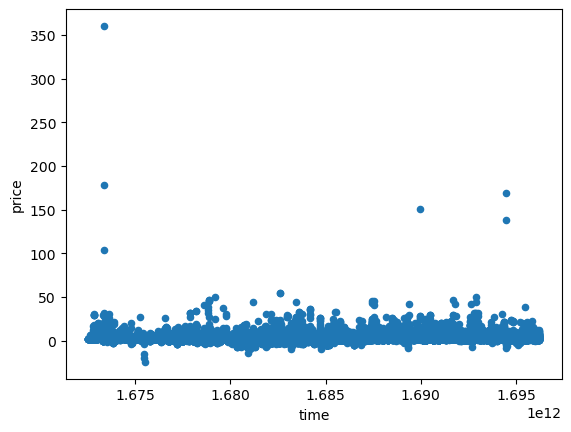

In [44]:
#Exploratory visualization
price_df.plot.scatter("time","price")

<Axes: >

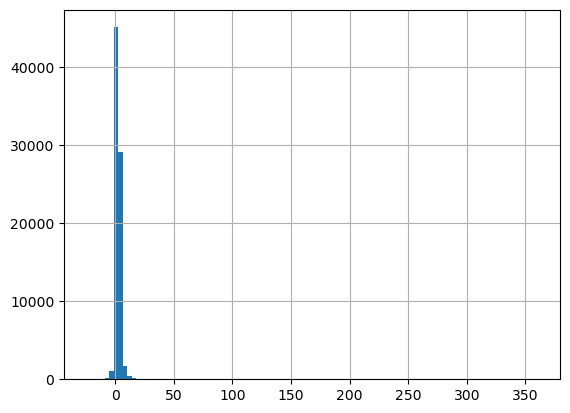

In [45]:
price_df["price"].hist(bins=100)

An exploratory analysis of the price data for 2023 reveals the presence of significant outliers, which make it difficult to observe any patterns in the data. A frequency analysis of the price data reveals that the vast majority of the data is between -10 and 20 cents per kilowatt-hour, so as a result we mask our data to remove any points outside of this range and repeat our visualizations.

<Axes: xlabel='time', ylabel='price'>

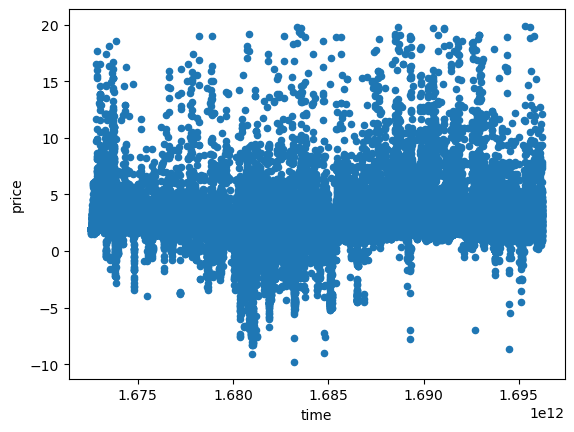

In [47]:
price_df = price_df[(price_df["price"] < 20) & (price_df["price"] > -10)]
price_df.plot.scatter("time","price")

Average price per kilowatt-hour: 2.5915


<Axes: >

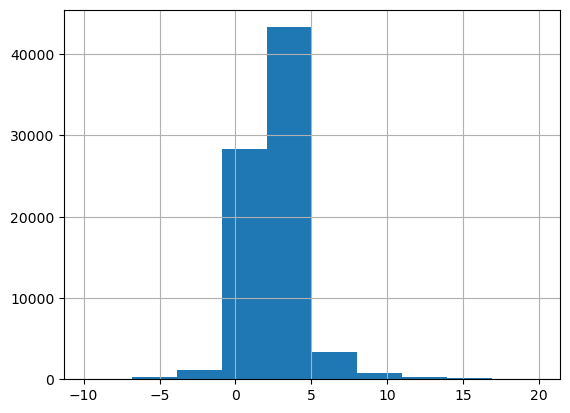

In [48]:
print("Average price per kilowatt-hour: {:.4f}".format(np.mean(price_df["price"])))
price_df["price"].hist()

With this filtered data, we can observe that the data is roughly normally distributed, with a mean of ~2.5 cents/kWh. On the timescale of a year, there is no apparent trend to the data, as price appears to be uniformly distributed over the year. The hope is that patterns will become more present as we reduce our timescale and add additional environmental data, converting our noisy price data into useful predictive data.

In [49]:
price_df["time"] = price_df["time"]/1000
price_df["datetime"] = price_df["time"].apply(datetime.datetime.fromtimestamp)
price_df.head()

,time,price,datetime
0,1.696222e+09,1.2,2023-10-02 00:55:00
1,1.696222e+09,1.1,2023-10-02 00:50:00
2,1.696222e+09,0.9,2023-10-02 00:45:00
3,1.696222e+09,1.0,2023-10-02 00:40:00
4,1.696221e+09,1.8,2023-10-02 00:35:00


In [50]:
price_df["datetime (str)"] = price_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
price_df[['date', 'time']] = price_df['datetime (str)'].str.split(' ', n=1, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02


In [51]:
price_df[["year", "month", "day"]] = price_df["date"].str.split("-", n=2, expand=True)
price_df[["hour", "minute", "second"]] = price_df["time"].str.split(":", n=2, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date,year,month,day,hour,minute,second
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02,2023,10,02,00,55,00
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02,2023,10,02,00,50,00
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02,2023,10,02,00,45,00
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02,2023,10,02,00,40,00
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02,2023,10,02,00,35,00


In [52]:
#Year and second can both be dropped, since we are currently only looking at 2023 data and our resolution is only 5 minutes
price_df.drop(columns=["year", "second", "datetime (str)"], inplace=True)
price_df.head()

,time,price,datetime,date,month,day,hour,minute
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02,10,02,00,55
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02,10,02,00,50
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02,10,02,00,45
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02,10,02,00,40
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02,10,02,00,35


While all of the data manipulation steps will remain listed above to provide insight into the thought process behind this data handling, they are condensed into the following function for use later in the project:

In [99]:
def load_price_data(url, upper_limit=20, lower_limit=-10):
    '''Load price data from API to dataframe 
    Input:
        url - (str), API url to extract the data from
        upper_limit - (float), Prices above this value will be considered outliers and removed
        lower_limit - (float), Prices below this value will be considered outliers and removed
    Output:
        price_df - (pandas dataframe), Containing price data broken out by various date/time formats'''
    
    price_json = requests.get(url)
    price_df = pd.read_json(price_json.text)
    #time is in millis UTC, price is cents/kWh
    price_df.columns = ["time", "price"]
    price_df = price_df[(price_df["price"] < upper_limit) & (price_df["price"] > lower_limit)] #Filter outliers
    price_df["time"] = price_df["time"]/1000
    price_df["datetime"] = price_df["time"].apply(datetime.datetime.fromtimestamp)
    price_df["datetime (str)"] = price_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    price_df[['date', 'time']] = price_df['datetime (str)'].str.split(' ', n=1, expand=True)
    price_df[["year", "month", "day"]] = price_df["date"].str.split("-", n=2, expand=True)
    price_df[["hour", "minute", "second"]] = price_df["time"].str.split(":", n=2, expand=True)
    price_df.drop(columns=["year", "second", "datetime (str)"], inplace=True)
    price_df["decimal time"] = price_df["hour"].astype(int) + price_df["minute"].astype(float)/60
    return price_df

<Axes: xlabel='datetime', ylabel='price'>

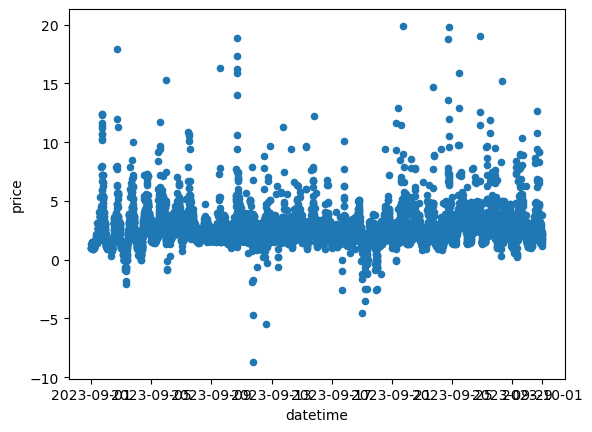

In [53]:
september_data = price_df[price_df["month"] == "09"]
september_data.plot.scatter("datetime","price")

<Axes: xlabel='datetime', ylabel='price'>

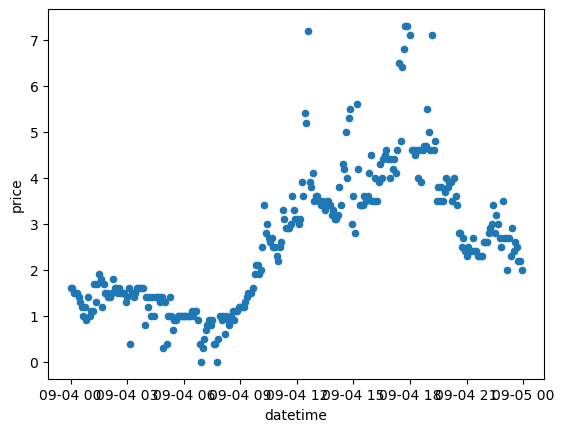

In [54]:
single_day = price_df[(price_df["month"] == "09") & (price_df["day"] == "04")]
single_day.plot.scatter("datetime", "price")

While there is no clear pattern in the price data at the year or month level, we can see a clear sinusoidal pattern emerge at the day scale. As expected, Energy prices are low late at night into the morning (approximately Midnight to 9 am), before increasing up to the daily peak (approximately noon to 6 pm), then declining back down in the evening. 

## Fitting Daily Model

<Axes: xlabel='decimal time', ylabel='price'>

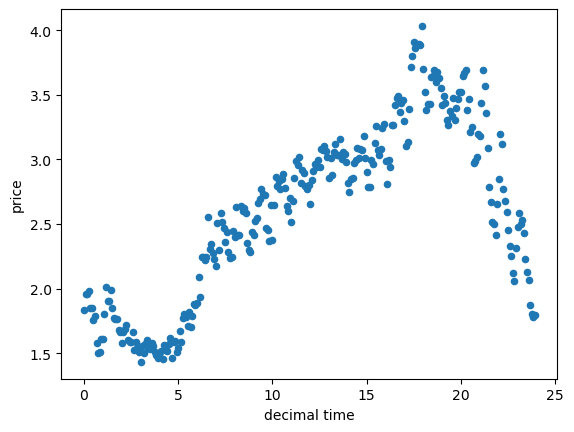

In [66]:
#Create decimal time column and groupby on it for curve fitting
price_df["decimal time"] = price_df["hour"].astype(int) + price_df["minute"].astype(float)/60
day_df = price_df.groupby(["decimal time"], as_index=False).mean()
day_df.plot.scatter("decimal time","price")

Standard Error of Regression: 0.2662


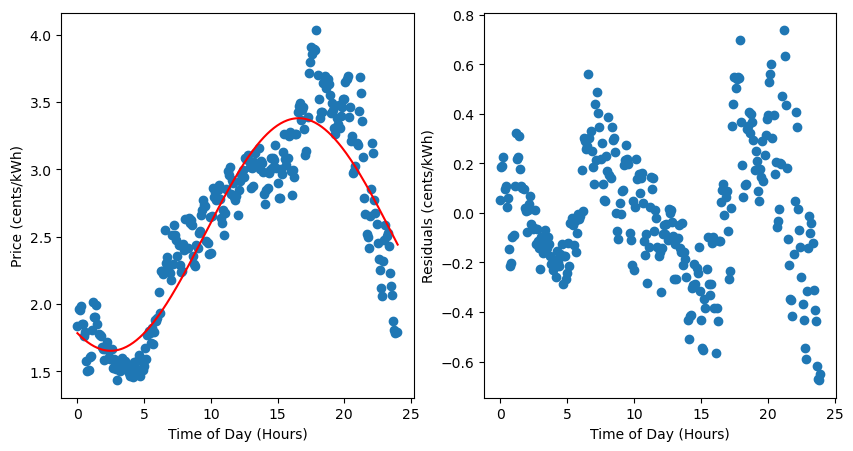

In [88]:
def sin(x,a,b,c,d):
    return a*np.sin(b*(x+c)) + d

cof, cov = sp.optimize.curve_fit(sin, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5])
x = np.linspace(0,24,288)
p_x = sin(x, *cof) #Predicted values (p(x))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r")
plt.scatter(day_df["decimal time"], day_df["price"])
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
#R-squared not valid for nonlinear model, use standard error of regression instead
residuals = day_df["price"] - p_x
plt.subplot(122)
plt.scatter(day_df["decimal time"], residuals)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Residuals (cents/kWh)")
print("Standard Error of Regression: {:.4f}".format((np.sum(residuals**2)/(len(residuals)-2))**0.5))

We can see from the above plot that fitting a simple sine function to the daily date does a good job capturing the pattern of data consumption throughout the day. Our residuals appear to show an additional sinusoidal pattern, which we will attempt to capture with an additional sinusoidal function. 

Standard Error of Regression: 0.1819


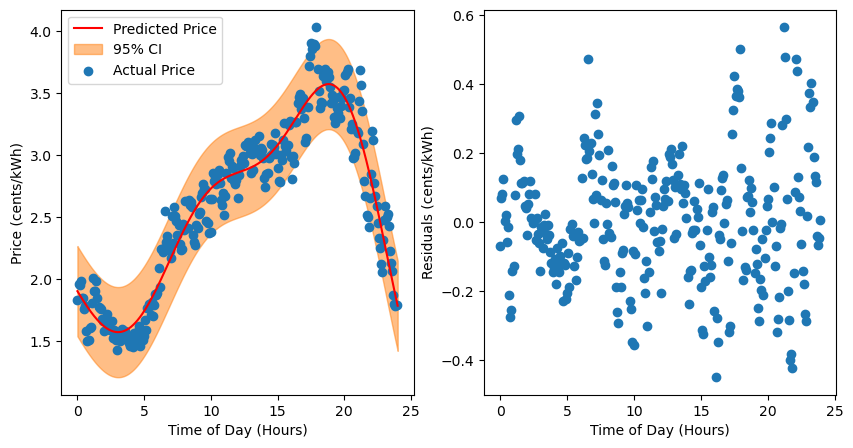

In [118]:
def adv_sinusoid(x,a,b,c,d,e,f,g,h):
    return (a*np.sin(b*(x+c)) + d) + (x*e*np.sin(f*(x+g)) + h)

cof, cov = sp.optimize.curve_fit(adv_sinusoid, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])
x = np.linspace(0,24,288)
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
residuals = day_df["price"] - p_x
standard_error = (np.sum(residuals**2)/(len(residuals)-2))**0.5
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.fill_between(x, p_x + 2*standard_error, p_x - 2*standard_error, alpha=0.5, label="95% CI", color="tab:orange")
plt.scatter(day_df["decimal time"], day_df["price"],color="tab:blue", label="Actual Price")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()
#R-squared not valid for nonlinear model, use standard error of regression instead
plt.subplot(122)
plt.scatter(day_df["decimal time"], residuals)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Residuals (cents/kWh)")

print("Standard Error of Regression: {:.4f}".format(standard_error))

We can see that the addition of this linear sinsuoid term to our base model greatly improves its fit, reducing the standard error of the regression, the maximum residual value, and removing any clear pattern from our residuals, leaving them randomly distributed. By applying the standard error, we can see that approximately 95% of our data points are within a range of +/- 0.36 cents/kWh from our model's prediction.

### Testing Simple Daily Model

Now that we have a model for the average fluctuations in electricity price over the course of a day, we will apply it to our data to evaluate how well it performs for a given day. In order to prevent our model from "training to the test", we will test on a subset of days selected outside the range of days our training data was drawn from. 

In [94]:
test_df = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202310020100&dateend=202310172359")
test_df.head()

,time,price,datetime,date,month,day,hour,minute,decimal time
0,00:55:00,2.7,2023-10-18 00:55:00,2023-10-18,10,18,00,55,0.916667
1,00:50:00,2.1,2023-10-18 00:50:00,2023-10-18,10,18,00,50,0.833333
2,00:45:00,3.2,2023-10-18 00:45:00,2023-10-18,10,18,00,45,0.750000
3,00:40:00,3.1,2023-10-18 00:40:00,2023-10-18,10,18,00,40,0.666667
4,00:35:00,3.5,2023-10-18 00:35:00,2023-10-18,10,18,00,35,0.583333


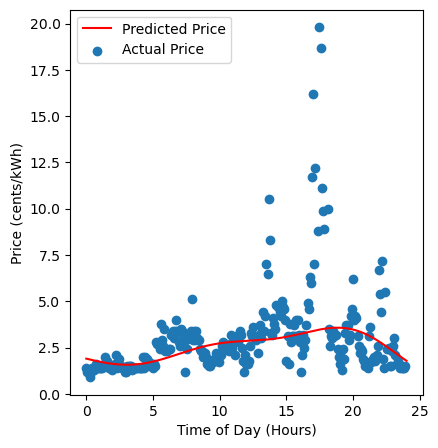

In [106]:
test_day_df = test_df[test_df["day"] == "03"]
x = np.linspace(0,24,288) #288 5-minute samples in a day
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.scatter(test_day_df["decimal time"], test_day_df["price"], label="Actual Price")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()

In [107]:
error = 0
n = 0
for i in range(2,18):
    test_day_df = test_df[test_df["day"].astype(int) == i]
    x = np.linspace(0,24,len(test_day_df["price"])) #288 5-minute samples in a day, but some are removed as outliers
    p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
    residuals = test_day_df["price"] - p_x
    error += np.sum(residuals**2)
    n += len(residuals)
    
print("Testing Data Standard Error of Regression: {:.4f}".format((error/(n-2))**0.5))

Testing Data Standard Error of Regression: 2.1911


We can see from the above standard error and exploratory plots that despite our model performing excellently on the averaged price data, it does not generalize well to predicting prices for individual days, due to the massive price variance day-to-day. While we were able to accurately predicted prices within +/- 0.36 cents/kWh on the averaged data, we are only able to predict prices within +/- 4.4 cents/kWh on the testing data, which represents nearly the entire range of the data. We aim to incorporate weather data to account for this day-to-day variance and reduce our model's error.

Standard Error of Regression: 0.7194


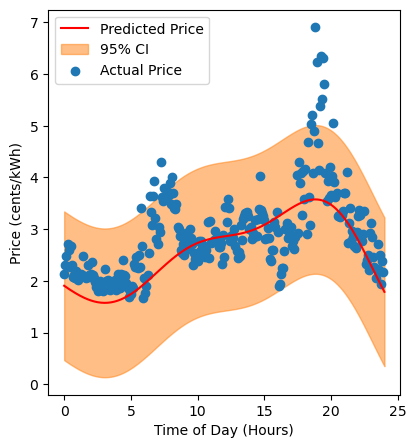

In [119]:
test_day_df = test_df.groupby(["decimal time"], as_index=False).mean()
x = np.linspace(0,24,288) #288 5-minute samples in a day
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
residuals = test_day_df["price"] - p_x
standard_error = (np.sum(residuals**2)/(len(residuals)-2))**0.5

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.fill_between(x, p_x + 2*standard_error, p_x - 2*standard_error, alpha=0.5, label="95% CI", color="tab:orange")
plt.scatter(test_day_df["decimal time"], test_day_df["price"], label="Actual Price", color="tab:blue")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()

print("Standard Error of Regression: {:.4f}".format(standard_error))

If we average our testing data (17 days) and then apply our model, we can see that it performs better than predicting on a day-by-day basis (+/- 1.4 cents/kWh instead of +/- 4.2 cents/kWh), but still significantly worse than our training set (+/- 0.36 cents/kWh). A visual inspection of this averaged testing data reveals that our model does accurately predict the general shape of the data, but fails to account for significant spikes around 7AM and 7PM.